In [1]:
import cv2
import dlib

import os
import matplotlib.pyplot as plt
import numpy as np

## 스티커 구하기 or 만들기

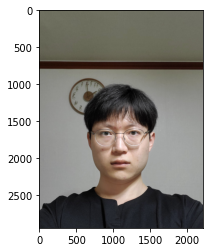

In [2]:
my_image_path = './images/front.jpg'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 출력용 이미지를 따로 보관.
img_bgr_copy = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # opencv가 인식한 bgr이미지를 rgb형태로 변환.
plt.imshow(img_rgb)
plt.show()

## 얼굴 검출 & 랜드마크 검출

rectangles[[(691, 1491) (1490, 2289)]]


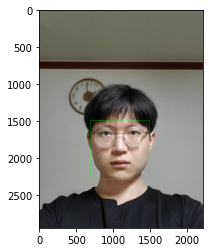

In [3]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [4]:
# dlib에서 제공하는 모델 사용. 공개된 weight file을 사용.
model_path = './models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
# landmark_predictor는 RGB 이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection을 반환
# dlib.rectangle: 내부를 예측하는 박스
# dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄.

In [5]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다.
# face landmark 좌표를 저장해둡니다.
for dlib_rect in dlib_rects:
    # 모든 landmark의 위치정보를 points 변수에 저장
    points = landmark_predictor(img_rgb, dlib_rect)
    # 각각의 landmark 위치 정보를 (x, y) 형태로 변환하여 list_points 리스트로 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
# 각 원소는 68개의 랜드마크 위치가 나열된 list
# list_landmarks의 원소가 1개이므로 list_landmarks[1]를 호출하면 IndexError.
print(len(list_landmarks[0]))

68


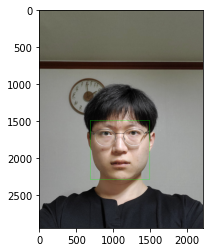

In [6]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용 위치 확인하기

![image](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)

In [7]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print(f'(x,y) : ({x}, {y})')
    print(f'(w,h) : ({w}, {h})')

(1087, 1874)
(x,y) : (1087, 1874)
(w,h) : (800, 800)


## 스티커 적용하기

In [8]:
sticker_path = './images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(800, 800, 3)


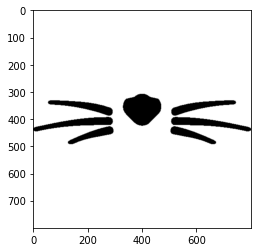

In [9]:
plt.imshow(img_sticker)

In [10]:
refined_x = x - w // 2
refined_y = y - h // 2

print(f'(x,y) : ({refined_x}, {refined_y})')

(x,y) : (687, 1474)


In [11]:
if refined_x < 0:
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print(f'(x,y) : ({refined_x}, {refined_y})')

(x,y) : (687, 1474)


In [12]:
sticker_area = img_show[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]]
img_show[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

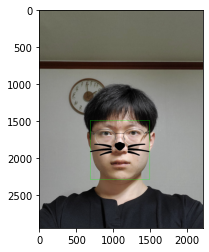

In [13]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 스티커를 좀더 자연스럽게 cv2.addWeighted()

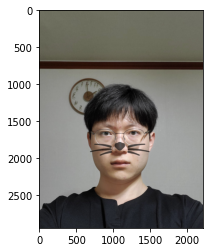

In [14]:
sticker_area = img_bgr[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]]
hide = cv2.addWeighted(sticker_area, 0.35, img_sticker, 0.65, 0)
img_bgr[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, hide).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점 찾아보기

## 여러 케이스를 시도하기위해 함수화

In [15]:
def sticker_image_generator(img_bgr):
    img_show = img_bgr.copy() # 출력용 이미지를 따로 보관.
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # opencv가 인식한 bgr이미지를 rgb형태로 변환.
    plt.imshow(img_rgb)
    plt.show()
    #
    detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환
    dlib_rects = detector_hog(img_rgb, 1)
    print(dlib_rects)

    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()
    #
    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)

        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    print(len(list_landmarks[0]))
    #
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()
    #
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        print(landmark[30])
        x = landmark[30][0]
        y = landmark[30][1]
        w = h = dlib_rect.width()
        print(f'(x,y) : ({x}, {y})')
        print(f'(w,h) : ({w}, {h})')
    #
    sticker_path = './images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    print(img_sticker.shape)
    #
    refined_x = x - w // 2
    refined_y = y - h // 2

    print(f'(x,y) : ({refined_x}, {refined_y})')
    #
    if refined_x < 0:
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0

    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    print(f'(x,y) : ({refined_x}, {refined_y})')
    #
    sticker_area = img_show[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]]
    img_show[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
    #
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    #
    sticker_area = img_bgr[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]]
    hide = cv2.addWeighted(sticker_area, 0.35, img_sticker, 0.65, 0)
    img_bgr[refined_y: refined_y + img_sticker.shape[0], refined_x: refined_x + img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area, hide).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

## 밝게

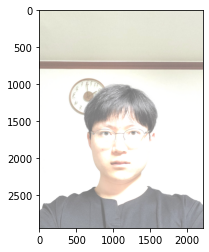

rectangles[[(691, 1491) (1490, 2289)]]


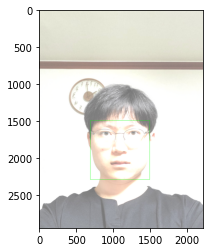

68


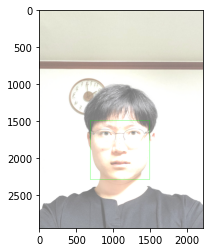

(1084, 1874)
(x,y) : (1084, 1874)
(w,h) : (800, 800)
(800, 800, 3)
(x,y) : (684, 1474)
(x,y) : (684, 1474)


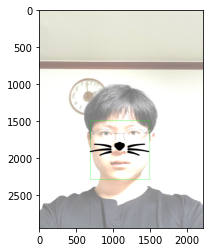

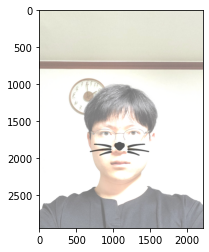

In [16]:
blighter = np.full(img_bgr.shape, (120, 120, 120), dtype=np.uint8)
img_bgr_b = cv2.add(img_bgr_copy, blighter)
sticker_image_generator(img_bgr_b)

## 좀더 밝게

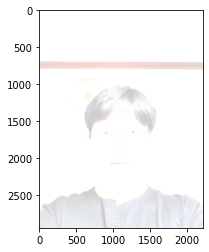

rectangles[]


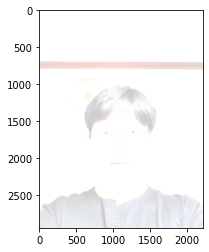

IndexError: list index out of range

In [17]:
blighter = np.full(img_bgr.shape, (200, 200, 200), dtype=np.uint8)
img_bgr_b = cv2.add(img_bgr_copy, blighter)
sticker_image_generator(img_bgr_b)

## 어둡게

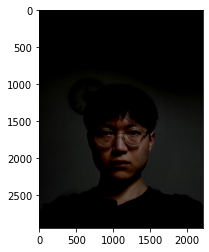

rectangles[[(617, 1363) (1575, 2321)]]


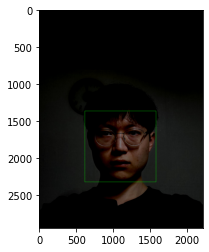

68


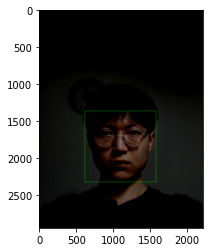

(1084, 1872)
(x,y) : (1084, 1872)
(w,h) : (959, 959)
(959, 959, 3)
(x,y) : (605, 1393)
(x,y) : (605, 1393)


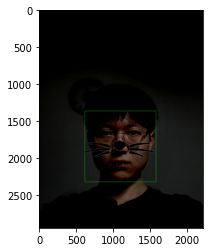

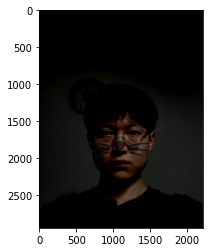

In [18]:
darker = np.full(img_bgr.shape, (-120, -120, -120), dtype=np.uint8)
img_bgr_d = cv2.subtract(img_bgr_copy, darker)
sticker_image_generator(img_bgr_d)

## 좀더 어둡게

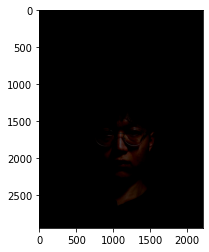

rectangles[]


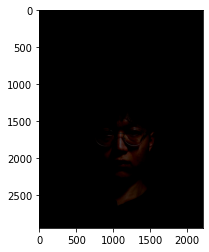

IndexError: list index out of range

In [19]:
darker = np.full(img_bgr.shape, (-70, -70, -70), dtype=np.uint8)
img_bgr_d = cv2.subtract(img_bgr_copy, darker)
sticker_image_generator(img_bgr_d)

## 왼쪽 40?

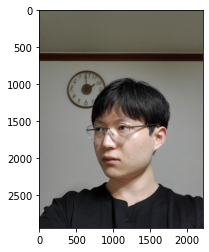

rectangles[[(510, 1256) (1469, 2215)]]


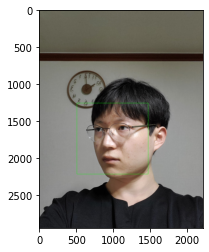

68


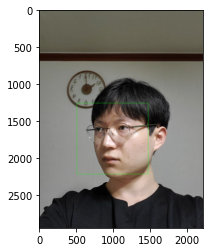

(897, 1814)
(x,y) : (897, 1814)
(w,h) : (960, 960)
(960, 960, 3)
(x,y) : (417, 1334)
(x,y) : (417, 1334)


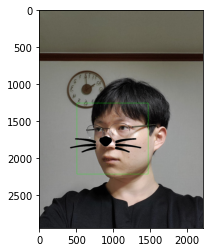

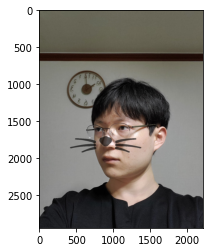

In [20]:
my_image_path = './images/left40.jpg'
img_bgr_l40 = cv2.imread(my_image_path)
sticker_image_generator(img_bgr_l40)

## 왼쪽 80?

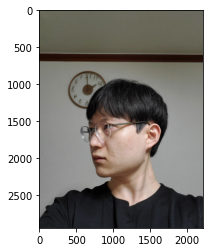

rectangles[[(404, 1256) (1362, 2215)]]


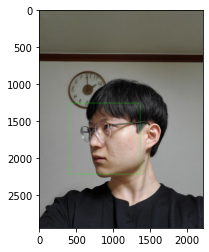

68


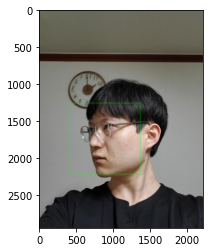

(695, 1809)
(x,y) : (695, 1809)
(w,h) : (959, 959)
(959, 959, 3)
(x,y) : (216, 1330)
(x,y) : (216, 1330)


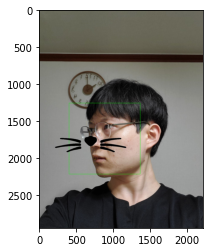

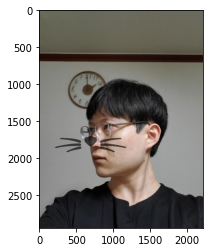

In [21]:
my_image_path = './images/left80.jpg'
img_bgr_l80 = cv2.imread(my_image_path)
sticker_image_generator(img_bgr_l80)

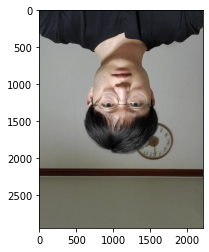

rectangles[]


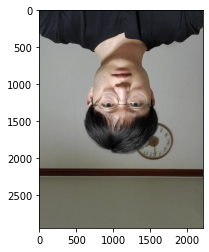

IndexError: list index out of range

In [23]:
img_bgr_180 = cv2.rotate(img_bgr_copy, cv2.ROTATE_180)
sticker_image_generator(img_bgr_180)

## 문제점에 대해서

### 이미지의 밝기
* 이미지의 밝기가 너무 밝거나 너무 어두우면 코부터 이미지가 사라지기 시작하면서 입과 얼굴형이 서서히 사라지기 시작해서 얼굴로 인식하지 못하는 문제가 발생하여 얼굴인식 모듈을 사용할 수 없게 됩니다. 해당 문제는 거리가 멀어지면서 이목구비를 구분할 수 없게되는 문제에도 비슷하게 적용됩니다.  

### 좌우 얼굴의 회전
* 이미지에서 사람이 얼굴이 왼쪽이나 오른쪽을 바라보고 있을 때, 스티커를 붙이면 얼굴의 좌우 변환에 따른 스케일링이 적용되지 않는 문제가 발생합니다, 해당 문제는 사진에서 사람이 왼쪽을 바라보고 있을 때, 스티커를 붙이면 사람이 얼굴이 왼쪽으로 회전한 만큼 스티커를 반으로 나눴을때, 왼쪽 부분의 가로길이가 줄어들고, 오른쪽 부분의 가로길이가 증가하여야 좀 더 자연스러운 느낌이 생길것 같은데, 그렇지 않았습니다.

    * 해당 문제는 스티커의 스케일링을 face detactor의 사각형을 기준으로 하지 않고, 아래의 landmark의 기준으로 하면 좀더 자연스러울것 같습니다.
예를 들어 지금 고양이 수염의 경우 하단 이미지의 30번을 중심으로 h를 19번과 8번의 길이로 잡고, w를 2번과 14번의 길이로 잡은 다음, 수염 이미지의 상하를 스케일링하고 반으로 나눈다음 왼쪽이미지를 2번과 30번의 x길이를 기준으로 스케일링하고, 오른쪽이미지를 30번과 14번의 x길이를 기준으로 스케일링한 다음 두 이미지를 합치면 가능하지 않을까 생각해보았습니다.

### 이미지의 회전
* 이미지의 사람 얼굴이 회전되었을 때는 얼굴로 인식하지 못하는 상황이 발생합니다. 아래의 그림처럼 어느정도 정위치에 있어야 랜드마크를 찍을 수 있는데 뒤집어진 이미지에서는 그 일정한 패턴을 파악할 수 없는 것 같습니다.

![image2](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)

# 회고

* 스티커앱들의 기초적인 부분을 만들어 보면서, 이미지에서 객체를 인식하는데 생기는 문제들을 겪게되어,  
    해당 문제들에 대해 개선할 방법들을 고민해 볼 수 있었던 시간이었습니다.

* 해당 라이브러리에서 제가 기능을 찾지 못한것인지, 아니면 없는 기능인지 잘 모르겠지만 좀 더 찾아보고 회전된 이미지를 인식하는 방법이 있다면, 해당 수치들을 기준으로 스티커도 같은 위치로 회전시켜서 능동적인 스티커 앱 기능을 만들어보면 좋을 것 같습니다.

* 좌우 얼굴의 회전부분에서 생각해본 방법은 가능성이 있으니 차후 한번 테스트 해봐야 할 것 같습니다. 물론 얼굴이 90도 정도 돌아가서 한쪽 눈이나 광대뼈 끝, 입 오른쪽 부분이 소실되어 얼굴을 인식할 수 없는 정도는 다른 라이브러리나 따로 만들어서 써야할것 같다는 생각이 듭니다.